# notebook 新功能介绍

现在，notebook 新增功能，支持运行回测（包括股票策略回测、期货策略回测及混合策略回测）及参数优化。

也就是说，notebook 中不仅可以方便地运行回测，还可以非常简便调整参数并获取自定义的回测报告。

首先，点击工具栏中最右侧的“生成回测代码模版”，选择“股票策略”，我们将看到如下的默认股票策略回测模版。

The rqalpha extension is already loaded. To reload it, use:
  %reload_ext rqalpha


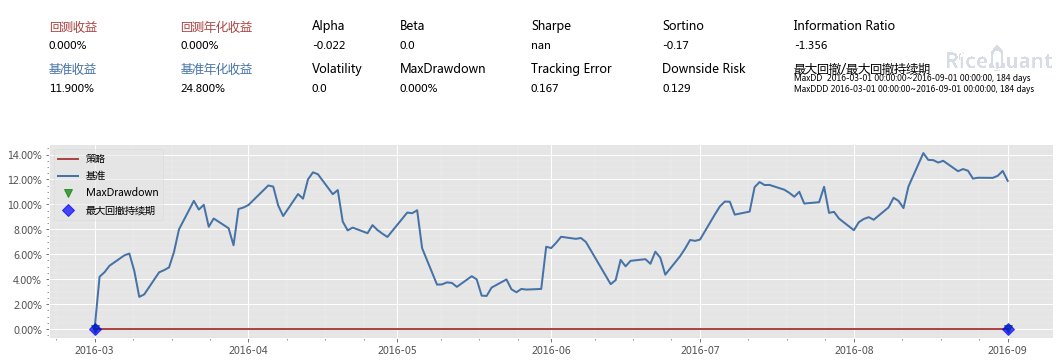

In [2]:
%load_ext rqalpha 
%rqalpha -s 20160301 -e 20160901 --account stock 100000 -fq 1d -p -bm 000001.XSHG
# 上述命令参数可以通过运行 %%rqalpha_plus -h 查看到
 
def init(context):
    # 策略初始化运行
    logger.info('init')
    context.counter = 0
    
def before_trading(context):
    # 每日开盘前运行
    pass
 
def handle_bar(context, bar_dict):
    # 每个 bar 数据运行
    context.counter += 1
    if context.counter == 1:
        order_shares('000001.XSHE', 100)
 
def after_trading(context):
    # 每日收盘后运行
    pass

## 回测模版中的命令参数

我们可以通过 

    %rqalpha_plus -h
    
    
来查看所有的命令参数。

其中比较常用的有：

    -s 回测起始日期

    -e 回测结束日期

    --account stock 100000 股票账户初始资金 100000

    -fq 回测评率 

    -p 打印回测结果

    -bm 市场基准

In [3]:
%rqalpha -h

## 获取回测报告

运行完回测后，报告会自动存储到 report 变量中。可以直接通过 report 变量获取当次回测的结果。

另外 notebook 的 mod 的输出会自动存储在 results 变量中。

In [4]:
results.keys()

['sys_analyser']

In [5]:
report.keys()

['trades',
 'stock_positions',
 'summary',
 'benchmark_portfolio',
 'portfolio',
 'stock_account']

例如我们想看一下回测的 summary，这将会非常方便：

In [6]:
report.summary

{u'STOCK': 100000.0,
 'alpha': -0.022,
 'annualized_returns': 0.0,
 'benchmark': u'000001.XSHG',
 'benchmark_annualized_returns': 0.248,
 'benchmark_total_returns': 0.119,
 'beta': 0.0,
 'cash': 100000.0,
 'downside_risk': 0.129,
 'end_date': '2016-09-01',
 'information_ratio': -1.356,
 'max_drawdown': 0.0,
 'run_type': 'BACKTEST',
 'sharpe': nan,
 'sortino': -0.17,
 'start_date': '2016-03-01',
 'strategy_file': 'strategy.py',
 'strategy_name': 'strategy',
 'total_returns': 0.0,
 'total_value': 100000.0,
 'tracking_error': 0.167,
 'unit_net_value': 1.0,
 'units': 100000.0,
 'volatility': 0.0}

# 回测功能

我们通过一个简单的“麦克•贝利 2-2-2 选股法则”来熟悉一下新的回测功能。

## 麦克•贝利简介

麦克•贝利(Michael Berry)，亚利桑那大学数量分析博士，财务研究专家，对美国股市具有深刻的研究经验，同时也是价值投资的拥护者。麦克•贝利在其发表的研究成果阐述了自己的价值投资理念，并发展出一种简单的选股标 准，称为 2-2-2 法则。

## 麦克•贝利 2-2-2 选股法则的通用版本

A. 股票预期市盈率低于市场平均预期市盈率的“2”分之一

B. 公司预期盈利成长率大于市场平均预估盈利成长率的“2”分之一

C. 股票的市净率小于“2”(此处我们选择“股票的市净率小于市场平均预估市净率的‘2’分之一”)

## 具体回测代码如下

In [8]:
%%rqalpha -s 20160101 -e 20170101 --account stock 100000 -fq 1d -p -bm 000001.XSHG
# 上述命令参数可以通过运行 %%rqalpha_plus -h 查看到
import numpy as np
import pandas as pd
import math
from pandas import Series
import statsmodels.api as sm
import talib as tb

# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init(context):
    # 在context中保存全局变量
    context.num = 20
    # 设置全局计数器，用于调仓次数的计数
    context.count = 0
    #context.stocks = []
    # 实时打印日志
    #logger.info("RunInfo: {}".format(context.run_info))
    if context.count % 4 == 0:
        scheduler.run_monthly(rebalance,1)
        context.count +=1
        
# before_trading此函数会在每天策略交易开始前被调用，当天只会被调用一次
def before_trading(context):
    all_df = get_fundamentals(      
            query(
                 fundamentals.eod_derivative_indicator.pb_ratio, # 市净率
                 fundamentals.eod_derivative_indicator.pe_ratio, # 市盈率
                 fundamentals.financial_indicator.earnings_per_share, # 每股收益 EPS
                 fundamentals.eod_derivative_indicator.market_cap # 总市值
                 #盈利成长率=每股业绩=每股收益EPS
            )
                )
    # dropna 返回一个仅含非空数据和索引值的 Series
    all_df = all_df.dropna(axis = 1,how = 'any')
    
    # 转置
    all_df = all_df.T
   
    # shape 用于读取矩阵的长度
    n = max(np.shape(all_df.values))
    #print(sum(all_df.values))
    # 计算（1/2 * 市场平均市净率）
    context.pb = (sum(all_df.values)/(2*n))[0]
    # 计算（1/2 * 市场平均市盈率）
    context.pe = (sum(all_df.values)/(2*n))[1]
    # 计算（1/2 * 市场平均每股收益）
    context.eps = (sum(all_df.values)/(2*n))[2]
    
    #print('pb='+str(context.pb))
    #print('pe='+str(context.pe))
    #print('eps='+str(context.eps))   
    
    
    all_df = all_df[all_df['pb_ratio']<2]
    all_df = all_df[all_df['pe_ratio']<context.pe]
    all_df = all_df[all_df['earnings_per_share']> context.eps]
    all_df = all_df.sort_values(by = 'market_cap',ascending = True)
    #logger.info('all_df'+str(all_df))
    all_df = all_df.head(context.num)
        
    context.all_df = all_df
    context.stocks = context.all_df.index.values
    #logger.info("选择好的股票列表为：" + str(context.stocks))
# 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
def rebalance(context, bar_dict):
    # 开始编写你的主要的算法逻辑
    # bar_dict[order_book_id] 可以拿到某个证券的bar信息
    # context.portfolio 可以拿到现在的投资组合信息
    # 使用order_shares(id_or_ins, amount)方法进行落单
    # TODO: 开始编写你的算法吧！
   
    average_weight = 0
    if len(context.stocks) != 0:
        average_weight = 0.999 / len(context.stocks)
        
        #开始进行调仓
        #先清仓持仓的股票不在新的列表中
    
    for stock in context.portfolio.positions:   #从已有持仓的股票中选取
        if stock not in context.stocks:         #如果不在新的股票列表里
            order_target_percent(stock,0)       #清仓
    
    if average_weight != 0:
        for stock in context.stocks:
            order_target_percent(stock,average_weight)

# after_trading函数会在每天交易结束后被调用，当天只会被调用一次
def after_trading(context):
    pass

## 获取自定义的回测报告

In [ ]:
report.summary

{'STOCK': 100000.0,
 'alpha': 0.30499999999999999,
 'annualized_returns': 0.27200000000000002,
 'benchmark': '000001.XSHG',
 'benchmark_annualized_returns': -0.058000000000000003,
 'benchmark_total_returns': -0.058000000000000003,
 'beta': 1.121,
 'cash': 16426.883000000002,
 'downside_risk': 0.067000000000000004,
 'end_date': '2016-12-30',
 'information_ratio': 2.8740000000000001,
 'max_drawdown': 0.19600000000000001,
 'run_type': 'BACKTEST',
 'sharpe': 0.91700000000000004,
 'sortino': 3.5430000000000001,
 'start_date': '2016-01-04',
 'strategy_file': 'strategy.py',
 'strategy_name': 'strategy',
 'total_returns': 0.27000000000000002,
 'total_value': 126976.883,
 'tracking_error': 0.104,
 'unit_net_value': 1.27,
 'units': 100000.0,
 'volatility': 0.26000000000000001}

In [ ]:
results["sys_analyser"]["trades"][:5]

commission     exec_id  last_price  last_quantity  \
datetime                                                                 
2016-01-04 15:00:00         5.0  1500276559       11.52            400   
2016-01-04 15:00:00         5.0  1500276560       11.92            400   
2016-01-04 15:00:00         5.0  1500276561        7.66            600   
2016-01-04 15:00:00         5.0  1500276562       17.04            200   
2016-01-04 15:00:00         5.0  1500276563        7.64            600   

                    order_book_id    order_id position_effect side symbol  \
datetime                                                                    
2016-01-04 15:00:00   600356.XSHG  1500276558            None  BUY   恒丰纸业   
2016-01-04 15:00:00   600051.XSHG  1500276559            None  BUY   宁波联合   
2016-01-04 15:00:00   002087.XSHE  1500276560            None  BUY   新野纺织   
2016-01-04 15:00:00   600969.XSHG  1500276561            None  BUY   郴电国际   
2016-01-04 15:00:00   000789.XSHE  1500276562            None  BUY    万年青   

                     tax     trading_datetime  transaction_cost  
datetime                                                         
2016-01-04 15:00:00  0.0  2016-01-04 15:00:00               5.0  
2016-01-04 15:00:00  0.0  2016-01-04 15:00:00               5.0  
2016-01-04 15:00:00  0.0  2016-01-04 15:00:00               5.0  
2016-01-04 15:00:00  0.0  2016-01-04 15:00:00               5.0  
2016-01-04 15:00:00  0.0  2016-01-04 15:00:00               5.0

我们来看一下部分交易记录

In [ ]:
report.trades[:5]

commission     exec_id  last_price  last_quantity  \
datetime                                                                 
2016-01-04 15:00:00         5.0  1500276559       11.52            400   
2016-01-04 15:00:00         5.0  1500276560       11.92            400   
2016-01-04 15:00:00         5.0  1500276561        7.66            600   
2016-01-04 15:00:00         5.0  1500276562       17.04            200   
2016-01-04 15:00:00         5.0  1500276563        7.64            600   

                    order_book_id    order_id position_effect side symbol  \
datetime                                                                    
2016-01-04 15:00:00   600356.XSHG  1500276558            None  BUY   恒丰纸业   
2016-01-04 15:00:00   600051.XSHG  1500276559            None  BUY   宁波联合   
2016-01-04 15:00:00   002087.XSHE  1500276560            None  BUY   新野纺织   
2016-01-04 15:00:00   600969.XSHG  1500276561            None  BUY   郴电国际   
2016-01-04 15:00:00   000789.XSHE  1500276562            None  BUY    万年青   

                     tax     trading_datetime  transaction_cost  
datetime                                                         
2016-01-04 15:00:00  0.0  2016-01-04 15:00:00               5.0  
2016-01-04 15:00:00  0.0  2016-01-04 15:00:00               5.0  
2016-01-04 15:00:00  0.0  2016-01-04 15:00:00               5.0  
2016-01-04 15:00:00  0.0  2016-01-04 15:00:00               5.0  
2016-01-04 15:00:00  0.0  2016-01-04 15:00:00               5.0

In [ ]:
from hmmlearn.hmm import GaussianHMM
import numpy as np
from matplotlib import cm, pyplot as plt
import matplotlib.dates as dates
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')

# 回测功能再认识

## 接下来是一个更为复杂的策略——HMM在股票市场中的应用

我们假设隐藏状态数量是6，即假设股市的状态有6种，虽然我们并不知道每种状态到底是什么，但是通过后面的图我们可以看出那种状态下市场是上涨的，哪种是震荡的，哪种是下跌的。可观测的特征状态我们选择了3个指标进行标示，进行预测的时候假设假设所有的特征向量的状态服从高斯分布，这样就可以使用<font color=#0099ff> hmmlearn </font>这个包中的<font color=#0099ff> GaussianHMM </font>进行预测了。下面我会逐步解释。

首先导入必要的包：

In [9]:
from hmmlearn.hmm import GaussianHMM
import numpy as np
from matplotlib import cm, pyplot as plt
import matplotlib.dates as dates
import pandas as pd
import datetime

测试时间从2005年1月1日到2015年12月31日，拿到每日沪深300的各种交易数据。

In [ ]:
beginDate = '2005-01-01'
endDate = '2015-12-31'
n = 6 #6个隐藏状态
data = get_price('CSI300.INDX',start_date=beginDate, end_date=endDate,frequency='1d')
data[0:9]

WARN: start_date is earlier than 2005-01-04, adjusted


open   close     high     low  total_turnover     volume
2005-01-04  994.77  982.79   994.77  980.66    4.431977e+09  7412869.0
2005-01-05  981.58  992.56   997.32  979.88    4.529208e+09  7119109.0
2005-01-06  993.33  983.17   993.79  980.33    3.921015e+09  6288028.0
2005-01-07  983.05  983.96   995.71  979.81    4.737469e+09  7298694.0
2005-01-10  983.76  993.88   993.96  979.79    3.762932e+09  5791697.0
2005-01-11  994.19  997.14   999.55  991.09    3.704076e+09  5849079.0
2005-01-12  996.65  996.75   996.98  989.26    3.093299e+09  5014525.0
2005-01-13  996.08  996.88   999.47  992.70    3.842173e+09  6044065.0
2005-01-14  996.62  988.31  1006.46  987.23    4.162921e+09  7297842.0

拿到每日成交量和收盘价的数据。

In [ ]:
volume = data['TotalVolumeTraded']
close = data['ClosingPx']

计算每日最高最低价格的对数差值，作为特征状态的一个指标。

In [ ]:
logDel = np.log(np.array(data['HighPx'])) - np.log(np.array(data['LowPx']))
logDel

array([ 0.01428574,  0.01764157,  0.01363667, ...,  0.01380317,
        0.01051247,  0.01207808])

计算每5日的指数对数收益差，作为特征状态的一个指标。

In [ ]:
logRet_1 = np.array(np.diff(np.log(close)))#这个作为后面计算收益使用
logRet_5 = np.log(np.array(close[5:])) - np.log(np.array(close[:-5]))
logRet_5

array([ 0.01449572,  0.00421252,  0.01384836, ..., -0.03007529,
       -0.02652464, -0.02603115])

计算每5日的指数成交量的对数差，作为特征状态的一个指标。

In [ ]:
logVol_5 = np.log(np.array(volume[5:])) - np.log(np.array(volume[:-5]))
logVol_5

array([-0.23693333, -0.35044388, -0.03957071, ..., -0.57079226,
       -0.67285963, -0.36793342])

由于计算中出现了以5天为单位的计算，所以要调整特征指标的长度。

In [ ]:
logDel = logDel[5:]
logRet_1 = logRet_1[4:]
close = close[5:]
Date = pd.to_datetime(data.index[5:])

把我们的特征状态合并在一起。

In [ ]:
A = np.column_stack([logDel,logRet_5,logVol_5])
A

array([[ 0.00849983,  0.01449572, -0.23693333],
       [ 0.00777352,  0.00421252, -0.35044388],
       [ 0.00679663,  0.01384836, -0.03957071],
       ..., 
       [ 0.01380317, -0.03007529, -0.57079226],
       [ 0.01051247, -0.02652464, -0.67285963],
       [ 0.01207808, -0.02603115, -0.36793342]])

下面运用<font color=#0099ff> hmmlearn </font>这个包中的<font color=#0099ff> GaussianHMM </font>进行预测。

In [ ]:
model = GaussianHMM(n_components= n, covariance_type="full", n_iter=2000).fit(A)
hidden_states = model.predict(A)
hidden_states

array([5, 5, 5, ..., 0, 0, 0])

关于<font color=#0099ff> covariance_type </font>的参数有下面四种：

spherical：是指在每个马尔可夫隐含状态下，可观察态向量的所有特性分量使用相同的方差值。对应协方差矩阵的非对角为0，对角值相等，即球面特性。这是最简单的高斯分布PDF。
diag：是指在每个马尔可夫隐含状态下，可观察态向量使用对角协方差矩阵。对应协方差矩阵非对角为0，对角值不相等。diag是hmmlearn里面的默认类型。
full：是指在每个马尔可夫隐含状态下，可观察态向量使用完全协方差矩阵。对应的协方差矩阵里面的元素都是不为零。
tied：是指所有的马尔可夫隐含状态使用相同的完全协方差矩阵。

这四种PDF类型里面，spherical, diag和full代表三种不同的高斯分布概率密度函数，而tied则可以看作是GaussianHMM和GMMHMM的特有实现。其中，full是最强大的，但是需要足够多的数据来做合理的参数估计；spherical是最简单的，通常用在数据不足或者硬件平台性能有限的情况之下；而diag则是这两者一个折中。在使用的时候，需要根据可观察态向量不同特性的相关性来选择合适的类型。

转自知乎用户Aubrey Li

我们把每个预测的状态用不同颜色标注在指数曲线上看一下结果。

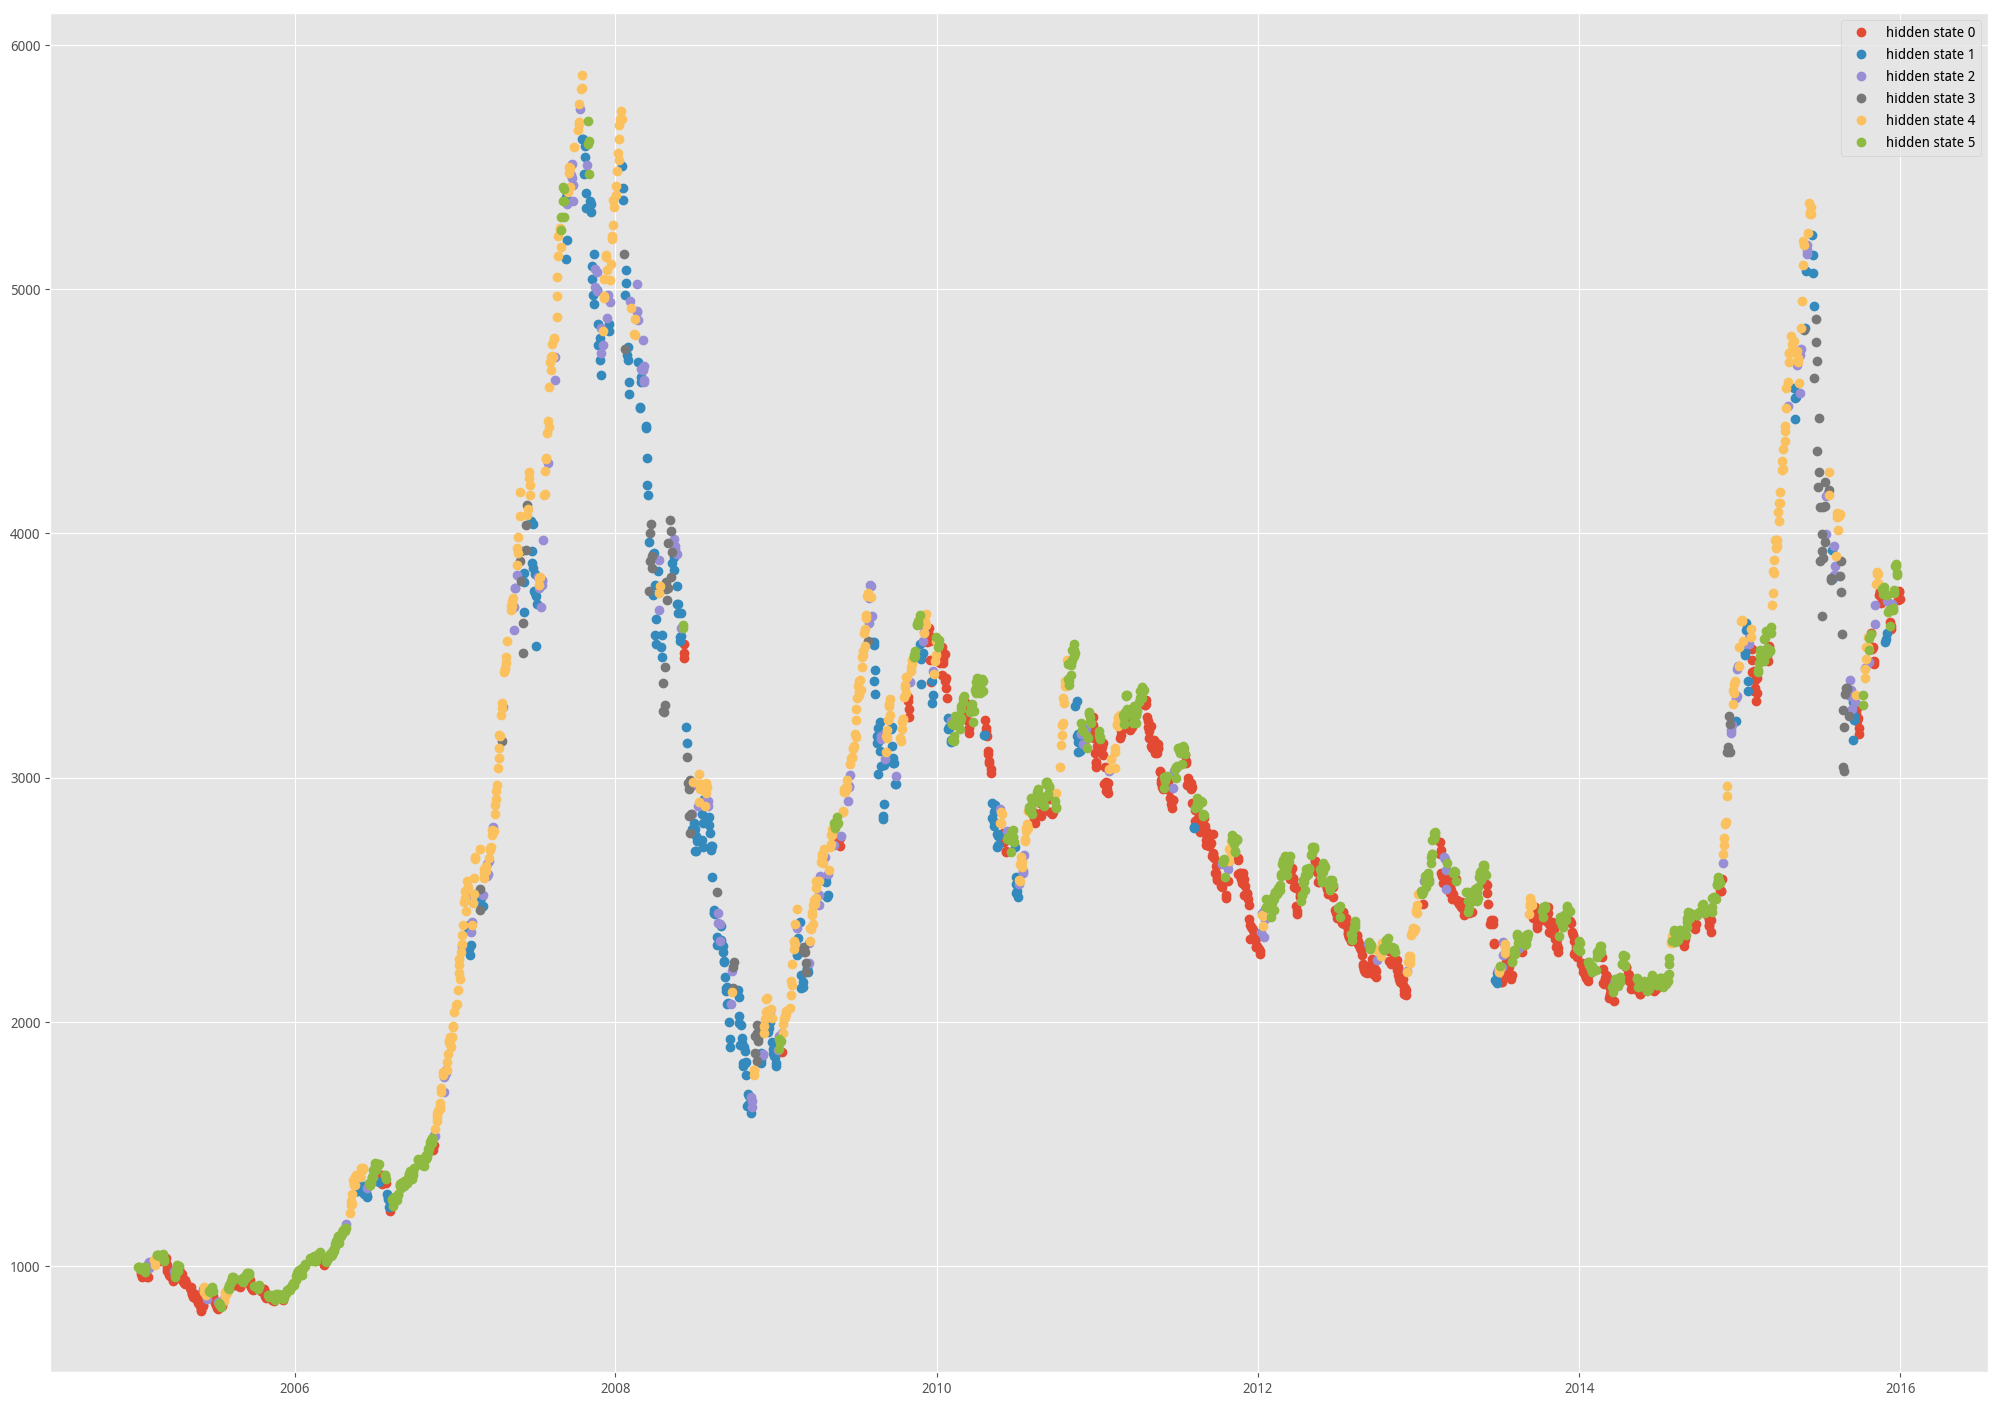

In [ ]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(25, 18)) 
for i in range(model.n_components):
    pos = (hidden_states==i)
    plt.plot_date(Date[pos],close[pos],'o',label='hidden state %d'%i,lw=2)
    plt.legend(loc="left")

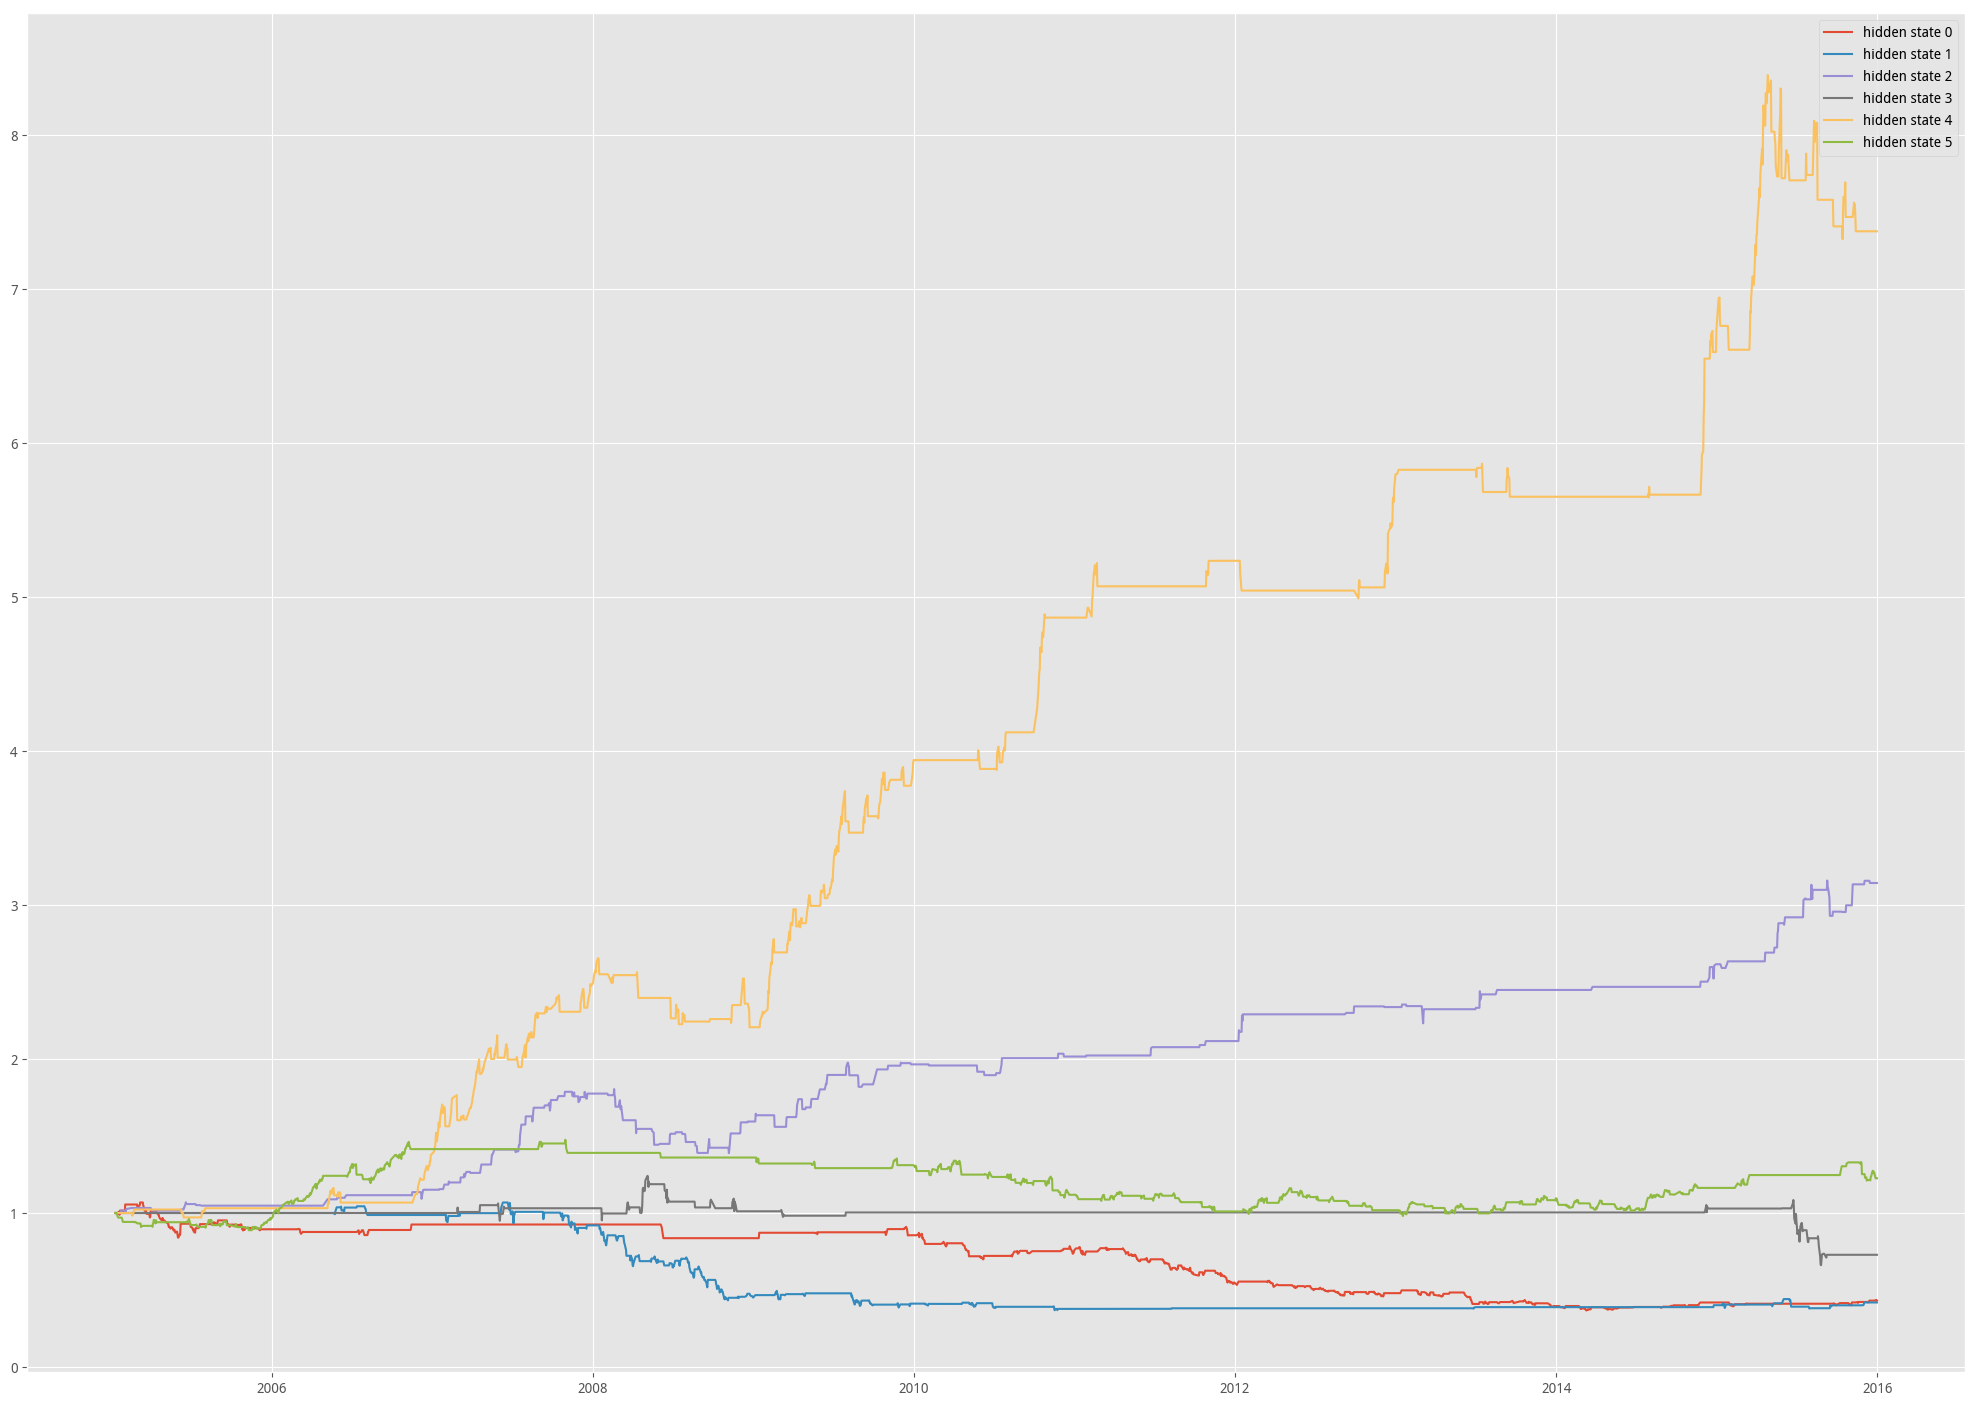

In [ ]:
res = pd.DataFrame({'Date':Date,'logRet_1':logRet_1,'state':hidden_states}).set_index('Date')
plt.figure(figsize=(25, 18)) 
for i in range(model.n_components):
    pos = (hidden_states==i)
    pos = np.append(0,pos[:-1])#第二天进行买入操作
    df = res.logRet_1
    res['state_ret%s'%i] = df.multiply(pos)
    plt.plot_date(Date,np.exp(res['state_ret%s'%i].cumsum()),'-',label='hidden state %d'%i)
    plt.legend(loc="left")

可以看到，隐藏状态1是一个明显的大牛市阶段，隐藏状态0是一个缓慢上涨的阶段(可能对应反弹)，隐藏状态3和5可以分别对应震荡下跌的大幅下跌。其他的两个隐藏状态并不是很明确。由于股指期货可以做空，我们可以进行如下操作：当处于状态0和1时第二天做多，当处于状态3和5第二天做空，其余状态则不持有。

In [ ]:
long = (hidden_states==0) + (hidden_states == 1) #做多
short = (hidden_states==3) + (hidden_states == 5)  #做空
long = np.append(0,long[:-1]) #第二天才能操作
short = np.append(0,short[:-1]) #第二天才能操作

收益曲线图如下：

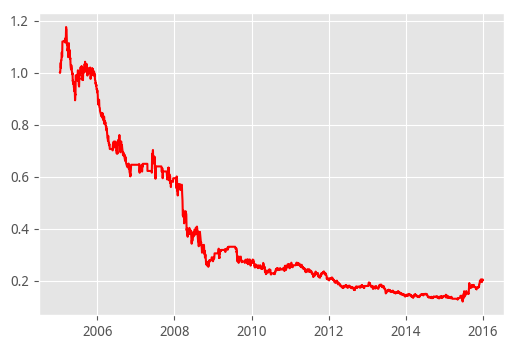

In [ ]:
res['ret'] =  df.multiply(long) - df.multiply(short)  
plt.plot_date(Date,np.exp(res['ret'].cumsum()),'r-')

可以看到效果还是很不错的。但事实上该结果是有些问题的。真实操作时，我们并没有未来的信息来训练模型。不过可以考虑用历史数据进行训练，再对之后的数据进行预测。

[2017-07-17 15:30:40.251022] DEBUG: system_log: 
{'base': {'accounts': {'STOCK': 100000.0},
          'benchmark': '000300.XSHG',
          'data_bundle_path': '/home/user_306344/.rqalpha-plus/bundle',
          'end_date': datetime.date(2016, 6, 30),
          'frequency': '1d',
          'margin_multiplier': 1,
          'persist': False,
          'persist_mode': PERSIST_MODE.REAL_TIME,
          'resume_mode': False,
          'run_type': RUN_TYPE.BACKTEST,
          'source_code': None,
          'start_date': datetime.date(2016, 1, 1),
          'strategy_file': 'strategy.py'},
 'extra': {'context_vars': None,
           'dividend_reinvestment': False,
           'enable_profiler': False,
           'force_run_init_when_pt_resume': False,
           'is_hold': False,
           'locale': 'zh_Hans_CN',
           'log_level': 'verbose',
           'user_log_disabled': False,
           'user_system_log_disabled': False},
 'mod': {'indicator': {'enabled': True, 'lib': 'rqalpha_mod_

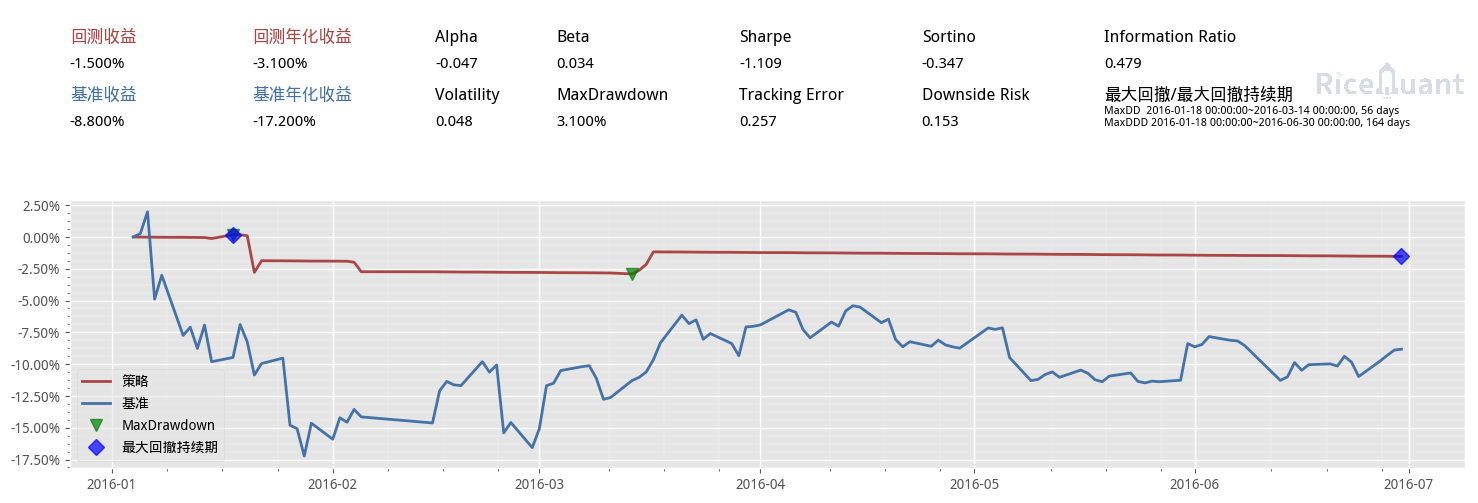

[2017-07-17 15:30:43.601510] DEBUG: system_log: 策略运行成功，正常退出


In [ ]:
from rqalpha_plus.api import *
from rqalpha_plus import run_func

from hmmlearn.hmm import GaussianHMM
import numpy as np
from matplotlib import cm, pyplot as plt
import matplotlib.dates as dates
import pandas as pd
import datetime

def init(context):
    # 策略初始化运行
    context.now
    context.stock = '000300.XSHG'
    context.A = 1
    
def before_trading(context):
    yesterday = (context.now-datetime.timedelta(days = 1)).strftime('%Y-%m-%d')
    ago = (context.now-datetime.timedelta(days = 100)).strftime('%Y-%m-%d')
    data = get_price('000300.XSHG',start_date = ago,end_date = yesterday)
    volume = data['volume']
    close = data['close']
    logDel = np.log(np.array(data['high'])) - np.log(np.array(data['low']))
    logRet_1 = np.array(np.diff(np.log(close)))#这个作为后面计算收益使用
    logRet_5 = np.log(np.array(close[5:])) - np.log(np.array(close[:-5]))
    logVol_5 = np.log(np.array(volume[5:])) - np.log(np.array(volume[:-5]))
    logDel = logDel[5:]
    logRet_1 = logRet_1[4:]
    close = close[5:]
    Date = pd.to_datetime(data.index[5:])
    A = np.column_stack([logDel,logRet_5,logVol_5])
    context.A = A
 
def handle_bar(context, bar_dict):
    # 每个 bar 数据运行
    hidden_states = model.predict(context.A)
    if hidden_states[-1] == 2:
        order_target_percent(context.stock,1)
    else:
        order_target_percent(context.stock,0)
 
def after_trading(context):
    # 每日收盘后运行
    pass

config = {
  "base": {
    "start_date": "2016-01-01",
    "end_date": "2016-06-30",
    "benchmark": "000300.XSHG",
    "accounts": {
                 'stock': 100000,
             } 
  },
  "extra": {
    "log_level": "verbose",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

# 您可以指定您要传递的参数
run_func(init=init, before_trading=before_trading, handle_bar=handle_bar, config=config)

from rqdatac import *

In [ ]:
get_price('000300.XSHG',start_date = '2017-07-05',end_date = '2017-07-05')

open      close       high        low  total_turnover  \
2017-07-05  3611.8984  3659.6795  3660.7291  3610.4586    1.203516e+11   

                  volume  
2017-07-05  8.823242e+09

In [ ]:
from rqdatac import *

# 参数调优

现在，notebook 不仅可以运行回测，更可以在其中进行参数调优，免去在策略页面中多次修改参数、多次回测的重复劳动。

下面，我们通过一个小例子来一窥究竟。

## 跨期合约价差研究

首先，我们发现 RU1605 和RU1606 的价差始终都处于比较平稳的状态，并且带有剧烈的波动，于是以历史两倍标准差作为动态开平仓线，进行跨期套利。

那么这个两倍标准差究竟是不是最优值呢？我们运用 notebook 的参数优化功能，以步长 0.1 考察标准差从 2 倍到 3 倍的情况。

我们把需要调整的参数放入 tasks，回测的主逻辑不变，并发运行回测，最终得到不同参数值下的一系列结果。

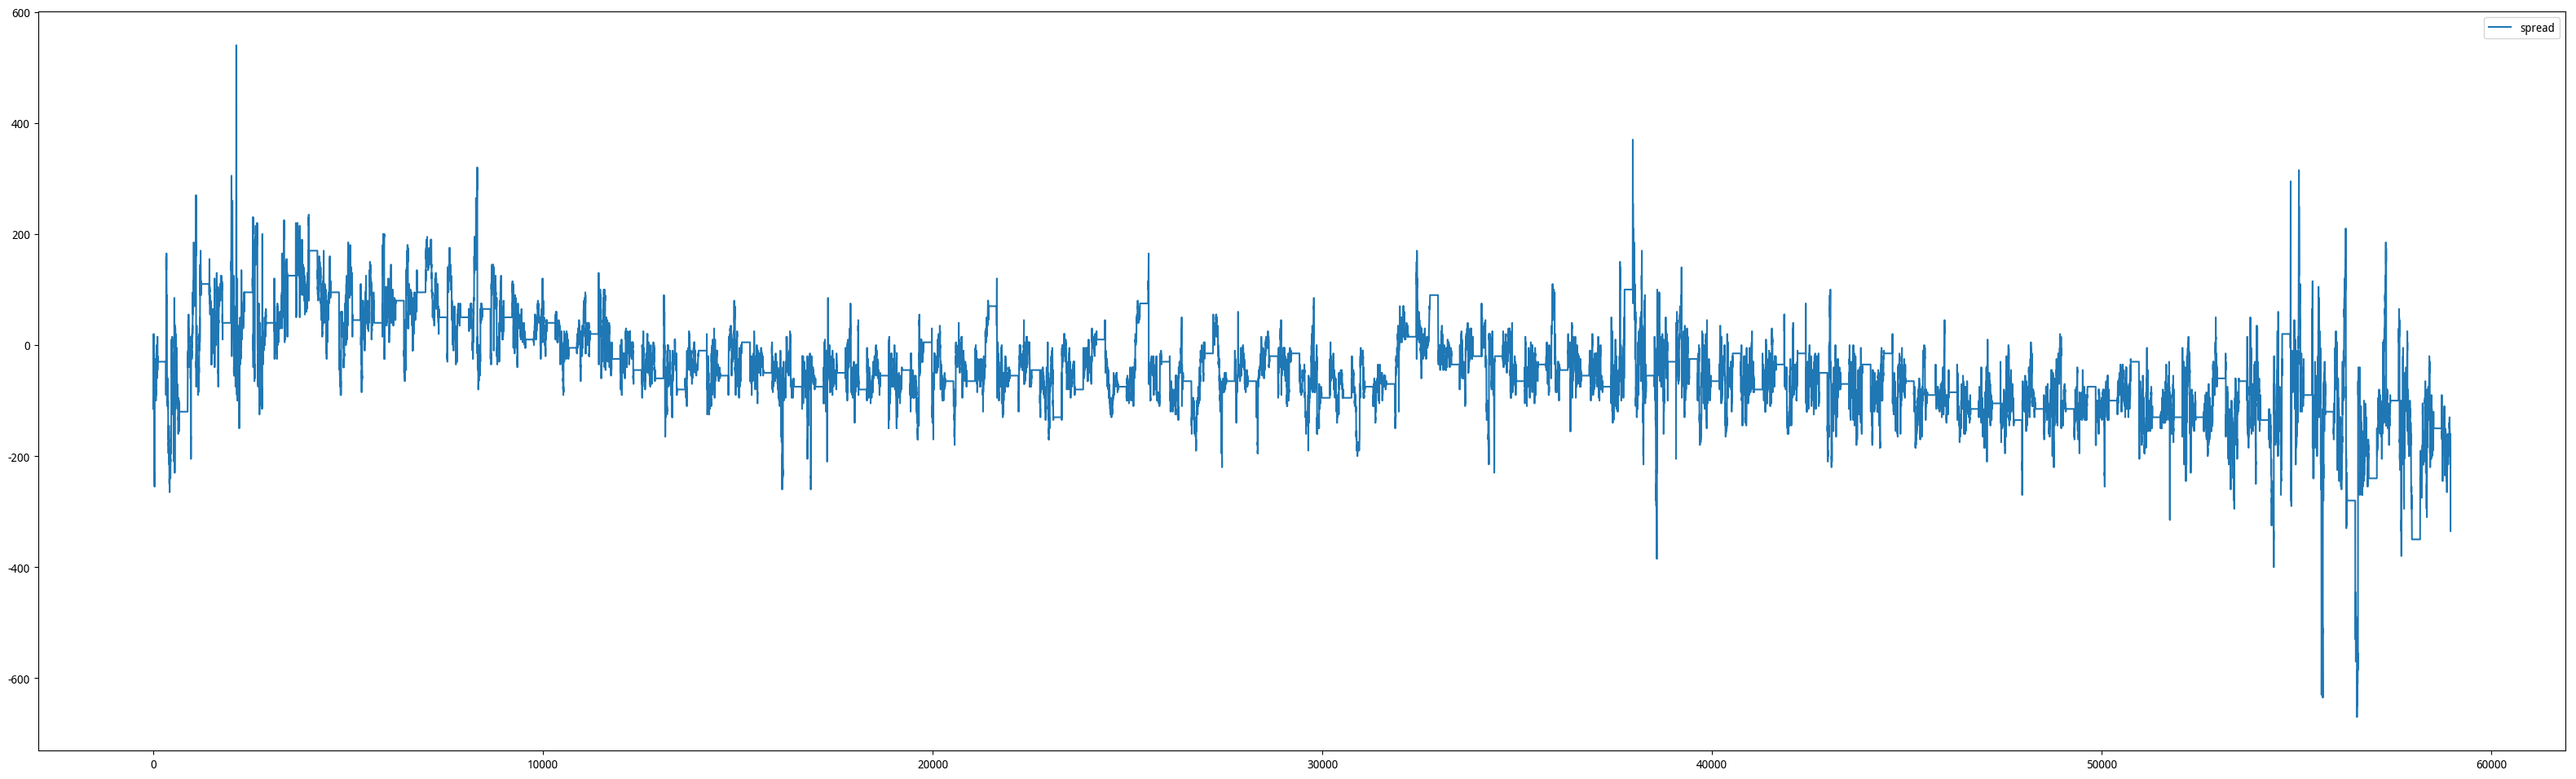

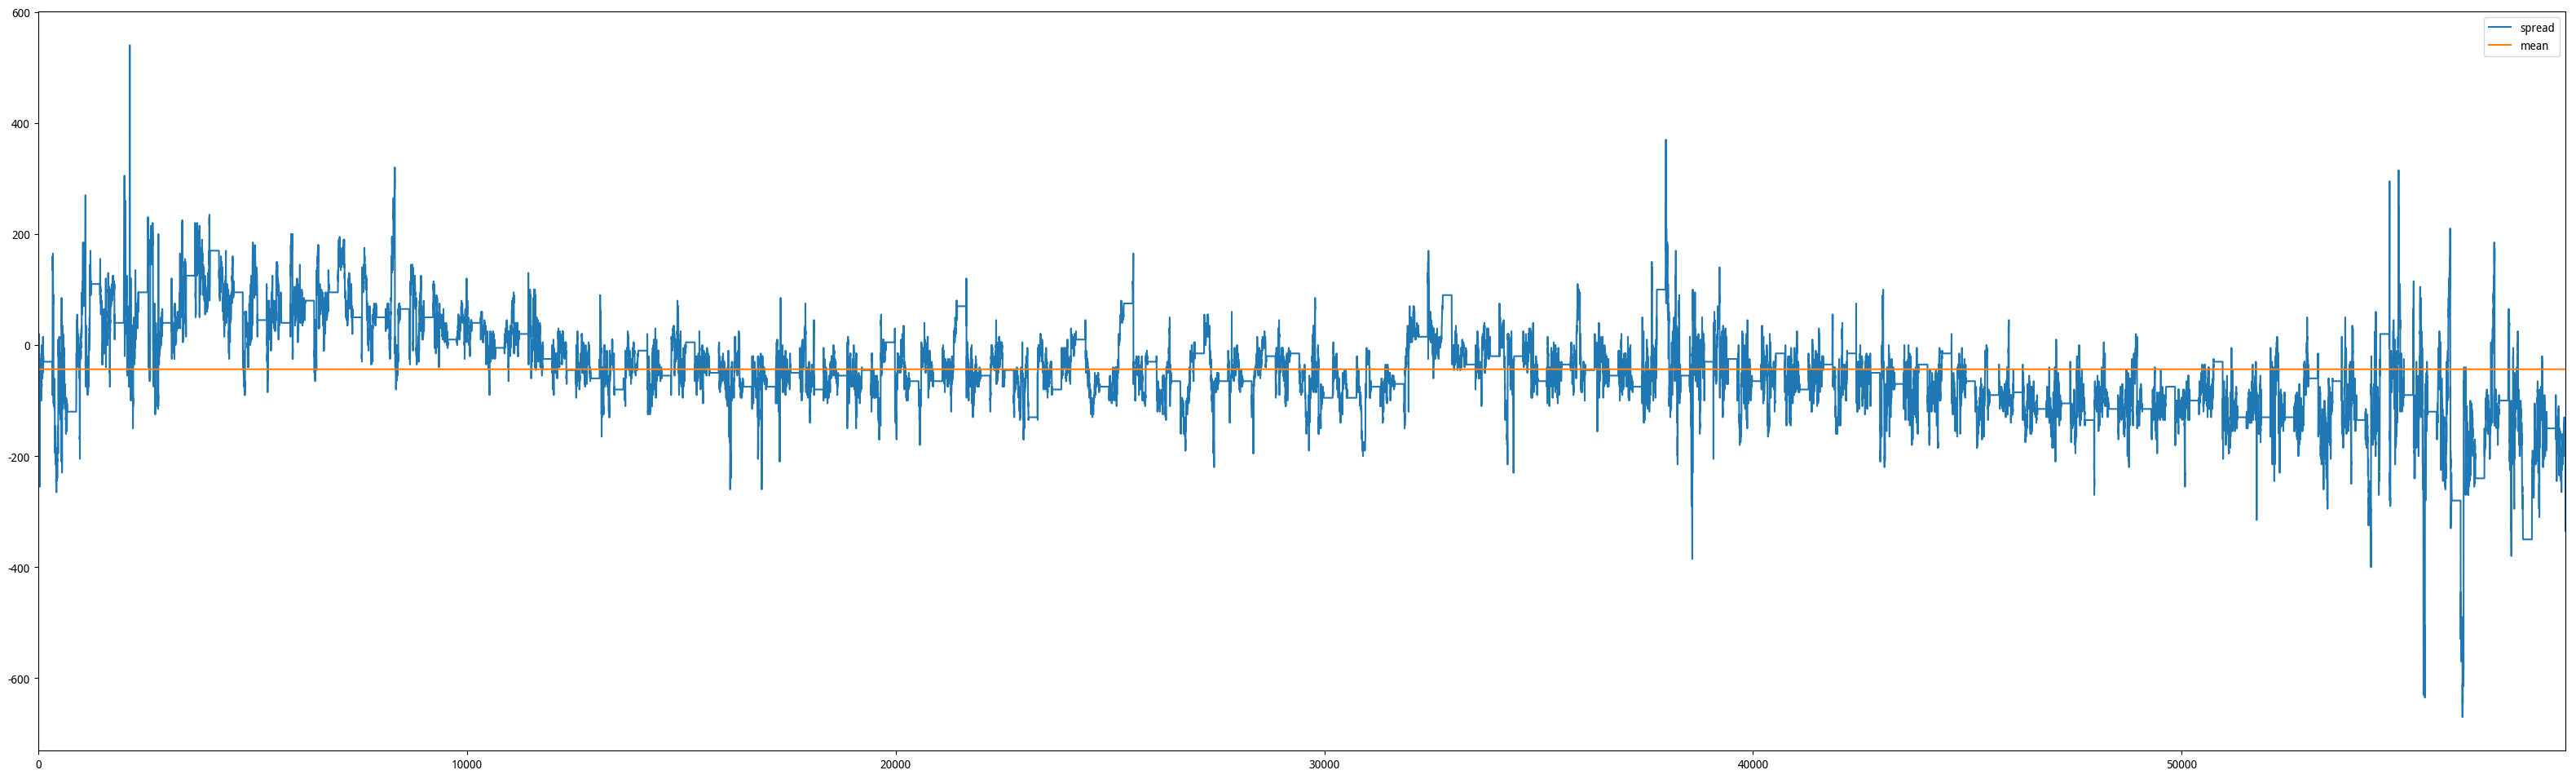

In [1]:
start_date='20151121'
end_date='20160430'
RU1605=get_price('RU1605',start_date=start_date,end_date=end_date,fields='close',frequency='1m') #当月
RU1606=get_price('RU1606',start_date=start_date,end_date=end_date,fields='close',frequency='1m') # 下月

spread=RU1605.values-RU1606.values

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=[40,12])
plt.plot(spread)
plt.legend(['spread'])

mean=np.ones(spread.shape)*np.mean(spread)
data=pd.DataFrame([spread,mean],index=['spread','mean']).T
data[['spread','mean']].plot(figsize=[40,12])

In [ ]:
%timeit
import concurrent.futures
import multiprocessing
from rqalpha_plus import run_func
from rqalpha_plus.api import *
import numpy as np
import warnings

warnings.filterwarnings("ignore")
max_workers = multiprocessing.cpu_count() - 1
max_workers = 2

config = {
    'extra': {
        'log_level': 'error',
    },
    'base': {
        'securities': 'future',
        'matching_type': 'current_bar',
        'start_date': '2015-12-01',
        'end_date': '2016-04-01',
        'accounts': {
                 'future': 100000,
             },
        'frequency': '1m',
    },
    'mod': {
        'sys_progress': {
            'enabled': False,
            'show': True,
        },
        'sys_analyser': {
            'enabled': True,
        },
    },
}

# 需要调优的参数放在 tasks 中
tasks = []
for entry_score in np.arange(2, 3, 0.1):
    tasks.append((config, entry_score))


def run_bt(config, entry_score):
    
    #回测代码
    # 可以自己import我们平台支持的第三方python模块，比如pandas、numpy等。
    import numpy as np


    # 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
    def init(context):
        context.s1 = 'RU1605'
        context.s2 = 'RU1609'

        # 设置全局计数器
        context.counter = 0

        # 设置滚动窗口
        context.window = 60

        # 设置对冲手数,通过研究历史数据进行价格序列回归得到该值
        context.ratio = entry_score

        context.up_cross_up_limit = False
        context.down_cross_down_limit = False

        # 设置入场临界值
        context.entry_score = entry_score

        # 初始化时订阅合约行情。订阅之后的合约行情会在handle_bar中进行更新
        subscribe([context.s1, context.s2])
        print(entry_score)


    # before_trading此函数会在每天交易开始前被调用，当天只会被调用一次
    def before_trading(context):
        # 样例商品期货在回测区间内有夜盘交易,所以在每日开盘前将计数器清零
        context.counter = 0


    # 你选择的期货数据更新将会触发此段逻辑，例如日线或分钟线更新
    def handle_bar(context, bar_dict):

        # 获取当前一对合约的仓位情况。如尚未有仓位,则对应持仓量都为0
        position_a = context.portfolio.positions[context.s1]
        position_b = context.portfolio.positions[context.s2]

        context.counter += 1
        # 当累积满一定数量的bar数据时候,进行交易逻辑的判断
        if context.counter > context.window:

            # 获取当天历史分钟线价格队列
            price_array_a = history_bars(context.s1, context.window, '1m', 'close')
            price_array_b = history_bars(context.s2, context.window, '1m', 'close')

            # 计算价差序列、其标准差、均值、上限、下限
            spread_array = price_array_a - context.ratio * price_array_b
            std = np.std(spread_array)
            mean = np.mean(spread_array)
            up_limit = mean + context.entry_score * std
            down_limit = mean - context.entry_score * std

            # 获取当前bar对应合约的收盘价格并计算价差
            price_a = bar_dict[context.s1].close
            price_b = bar_dict[context.s2].close
            spread = price_a - context.ratio * price_b

            # 如果价差低于预先计算得到的下限,则为建仓信号,'买入'价差合约
            if spread <= down_limit and not context.down_cross_down_limit:
                # 可以通过logger打印日志
                # logger.info('spread: {}, mean: {}, down_limit: {}'.format(spread, mean, down_limit))
                # logger.info('创建买入价差中...')

                # 获取当前剩余的应建仓的数量
                qty_a = 1 - position_a.buy_quantity
                qty_b = context.ratio - position_b.sell_quantity

                # 由于存在成交不超过下一bar成交量25%的限制,所以可能要通过多次发单成交才能够成功建仓
                if qty_a > 0:
                    buy_open(context.s1, qty_a)
                if qty_b > 0:
                    sell_open(context.s2, qty_b)
                if qty_a == 0 and qty_b == 0:
                    # 已成功建立价差的'多仓'
                    context.down_cross_down_limit = True
                    # logger.info('买入价差仓位创建成功!')

            # 如果价差向上回归移动平均线,则为平仓信号
            if spread >= mean and context.down_cross_down_limit:
                # logger.info('spread: {}, mean: {}, down_limit: {}'.format(spread, mean, down_limit))
                # logger.info('对买入价差仓位进行平仓操作中...')

                # 由于存在成交不超过下一bar成交量25%的限制,所以可能要通过多次发单成交才能够成功建仓
                qty_a = position_a.buy_quantity
                qty_b = position_b.sell_quantity
                if qty_a > 0:
                    sell_close(context.s1, qty_a)
                if qty_b > 0:
                    buy_close(context.s2, qty_b)
                if qty_a == 0 and qty_b == 0:
                    context.down_cross_down_limit = False
                    # logger.info('买入价差仓位平仓成功!')

            # 如果价差高于预先计算得到的上限,则为建仓信号,'卖出'价差合约
            if spread >= up_limit and not context.up_cross_up_limit:
                # logger.info('spread: {}, mean: {}, up_limit: {}'.format(spread, mean, up_limit))
                # logger.info('创建卖出价差中...')
                qty_a = 1 - position_a.sell_quantity
                qty_b = context.ratio - position_b.buy_quantity
                if qty_a > 0:
                    sell_open(context.s1, qty_a)
                if qty_b > 0:
                    buy_open(context.s2, qty_b)
                if qty_a == 0 and qty_b == 0:
                    context.up_cross_up_limit = True
                    # logger.info('卖出价差仓位创建成功')

            # 如果价差向下回归移动平均线,则为平仓信号
            if spread < mean and context.up_cross_up_limit:
                # logger.info('spread: {}, mean: {}, up_limit: {}'.format(spread, mean, up_limit))
                # logger.info('对卖出价差仓位进行平仓操作中...')
                qty_a = position_a.sell_quantity
                qty_b = position_b.buy_quantity
                if qty_a > 0:
                    buy_close(context.s1, qty_a)
                if qty_b > 0:
                    sell_close(context.s2, qty_b)
                if qty_a == 0 and qty_b == 0:
                    context.up_cross_up_limit = False
                    # logger.info('卖出价差仓位平仓成功!')

            
            
    name = '{}'.format(entry_score)
    try:
        result = run_func(config=config, init=init, handle_bar=handle_bar)
    except Exception as e:
        print(e)
        return

    return result, name


# 并发运行回测
futures = []
with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    for task in tasks:
        future = executor.submit(run_bt, *task)
        
        futures.append(future)
      
  
#获取回测结果
results = []
for future in futures:

    result, name = future.result()
    results.append((result['sys_analyser'], name))
    
    
# 从回测结果中提取分析信息
data = []
for task in tasks:
    result, name = run_bt(*task)
    #print(result,name)
    result = result['sys_analyser']
    summary = result['summary']
    data.append({
        'name': name,
        'annualized_returns': summary['annualized_returns'],
        'sharpe': summary['sharpe'],
        'max_drawdown': summary['max_drawdown'],
    })    
    
    
# 分析回测
results_df = pd.DataFrame(data)
 
print('')
print('-' * 50)
print('Sort by sharpe')
print(results_df.sort_values('sharpe', ascending=False)[:10])
 
print('-' * 50)
print('Sort by annualized_returns')
print(results_df.sort_values('annualized_returns', ascending=False)[:10])

from rqdatac import *

# 结语
以上就是本次 notebook 更新的新功能，大家快来试试吧！